## **Gerekli Kütüphanelerin Kurulumu ve Aktarılması**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization
import matplotlib.image as mpimg

In [16]:
warnings.filterwarnings("ignore")

In [17]:
label= []
path= []
fish_dir= "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
for dir_name,_,filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]== ".png":
            if dir_name.split()[-1] != "GT":
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))
                
data= pd.DataFrame(columns=["path","label"])
data["path"]= path
data["label"]= label

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [19]:
data.head(5)

path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

## **Veri Seti Görselleştirme**

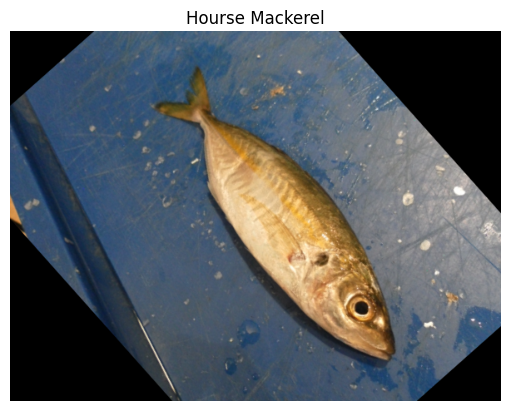

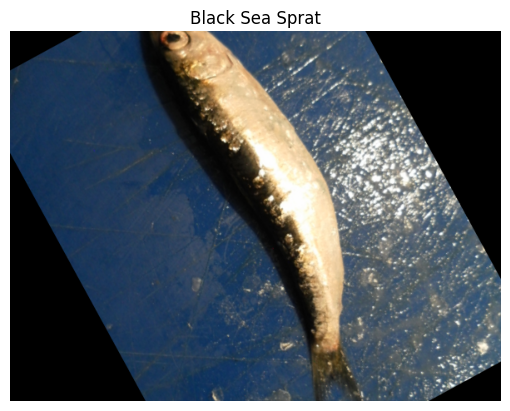

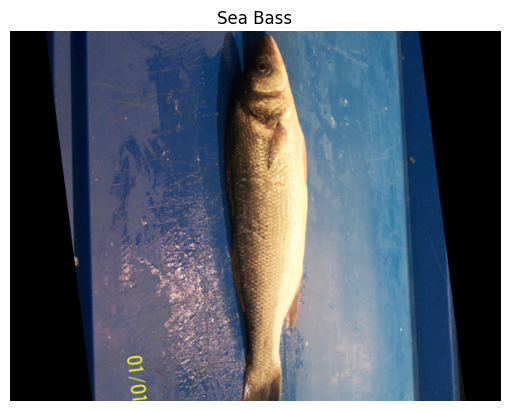

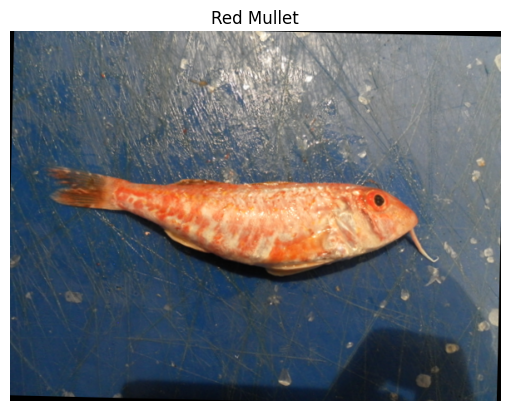

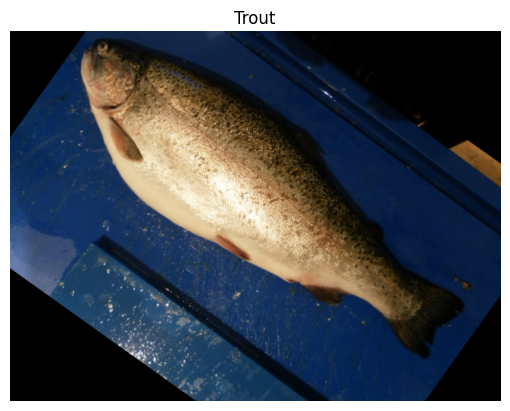

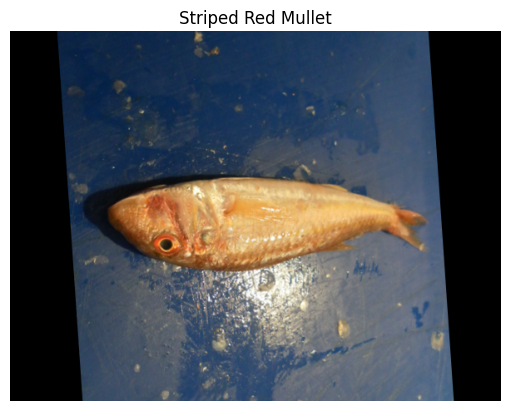

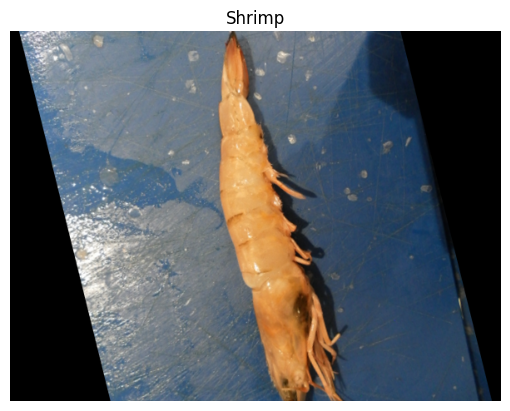

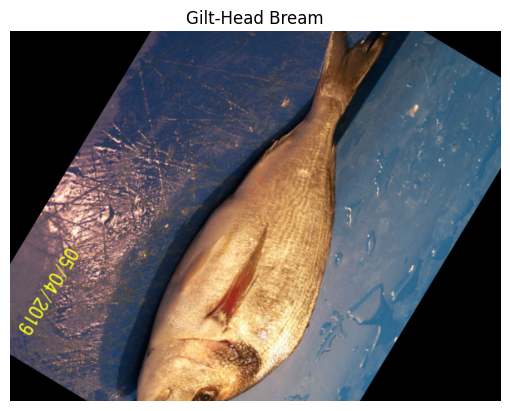

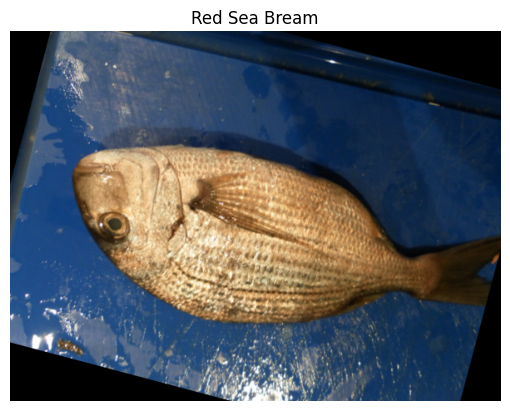

In [20]:
unique_labels = data.drop_duplicates(subset="label")

for i in range(len(unique_labels)):
    img_path = unique_labels["path"].iloc[i]
    label = unique_labels["label"].iloc[i]
    img = mpimg.imread(img_path)
    
    plt.figure()
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

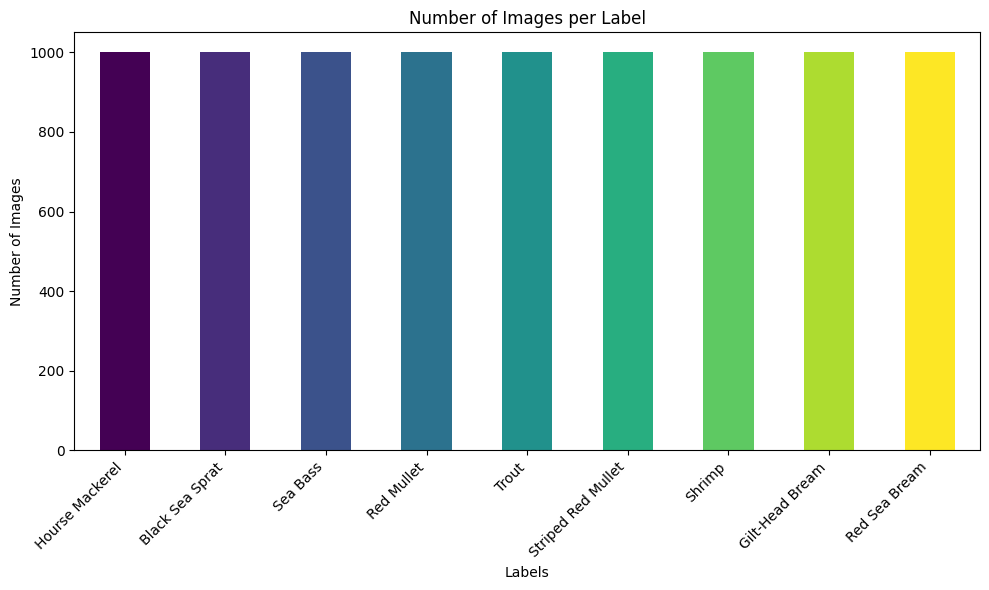

In [21]:
label_counts= data["label"].value_counts()
colors = plt.cm.get_cmap('viridis', len(label_counts)) # her bir bar'ın farkli renkte olmasını istedim:)
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar', color=[colors(i) for i in range(len(label_counts))])
plt.title("Number of Images per Label")
plt.xlabel("Labels")
plt.ylabel("Number of Images")

plt.xticks(rotation=45,ha="right") #Label'lar birbirini engellemesin diye 45 derece sağ döndürülecek.
plt.tight_layout() #Grafiklerin taşmasını engeller.
plt.show()

In [22]:
encoder= OneHotEncoder(sparse=False)
labels_encoded= encoder.fit_transform(data["label"].values.reshape(-1,1))

In [23]:
labels_encoded

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
X_train,X_test,y_train,y_test= train_test_split(data["path"],labels_encoded,test_size=0.2,random_state=42)

## **Veri Ön İşleme(Image Preprocessing)**

In [25]:
img_size= (128,128)
def preprocessing_img(image_path):
    img=load_img(image_path,target_size=img_size)
    img_array= img_to_array(img)
    img_array= img_array / 255.0 #normalization işlemi nedeni ise pixel boyutlarını küçültüp eğitimi kısaltmak için
    return img_array
    


In [26]:
from concurrent.futures import ThreadPoolExecutor

def preprocess_images_multithread(img_paths):
    with ThreadPoolExecutor() as executor:
        processed_images = list(executor.map(preprocessing_img, img_paths))
    return np.array(processed_images)

X_train_processed = preprocess_images_multithread(X_train)
X_test_processed = preprocess_images_multithread(X_test)

## **Model Oluşturma**

In [27]:
model = Sequential()

model.add(Flatten(input_shape=(128, 128, 3)))

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation="relu"))


model.add(Dense(labels_encoded.shape[1], activation='softmax'))


In [28]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,355,913 (96.73 MB)

 Trainable params: 25,355,913 (96.73 MB)

 Non-trainable params: 0 (0.00 B)

* optimizer=Adam(learning_rate=1e-4): Modelin ağırlıklarını güncellemek için Adam optimizasyon algoritmasını kullanıldı. Öğrenme oranı **1e-4 (0.0001)** olarak ayarlanmış, bu nispeten düşük bir öğrenme oranıdır, modelin daha yavaş ve hassas öğrenmesini sağlar.


In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [30]:
history = model.fit(
    X_train_processed,
    y_train,
    epochs=30,          
    validation_data=(X_test_processed, y_test),
    callbacks=[early_stopping]
    
)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 304ms/step - accuracy: 0.1344 - loss: 2.2946 - val_accuracy: 0.2878 - val_loss: 1.9598
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 289ms/step - accuracy: 0.2586 - loss: 1.9533 - val_accuracy: 0.4939 - val_loss: 1.5453
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 288ms/step - accuracy: 0.3609 - loss: 1.6858 - val_accuracy: 0.4922 - val_loss: 1.4493
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - accuracy: 0.4645 - loss: 1.4535 - val_accuracy: 0.5806 - val_loss: 1.1903
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 290ms/step - accuracy: 0.5288 - loss: 1.2970 - val_accuracy: 0.6394 - val_loss: 1.0307
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 290ms/step - accuracy: 0.5675 - loss: 1.1884 - val_accuracy: 0.6283 - val_loss: 1.0103
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 288ms/step - accuracy: 0.6197 - loss: 1.0656 - val_accuracy: 0.7100 - val_loss: 0.8040
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 288ms/step - accuracy: 0.6554 - loss: 0

In [31]:
test_loss, test_acc = model.evaluate(X_test_processed, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9342 - loss: 0.2265
Test Loss: 0.17582665383815765, Test Accuracy: 0.9433333277702332


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


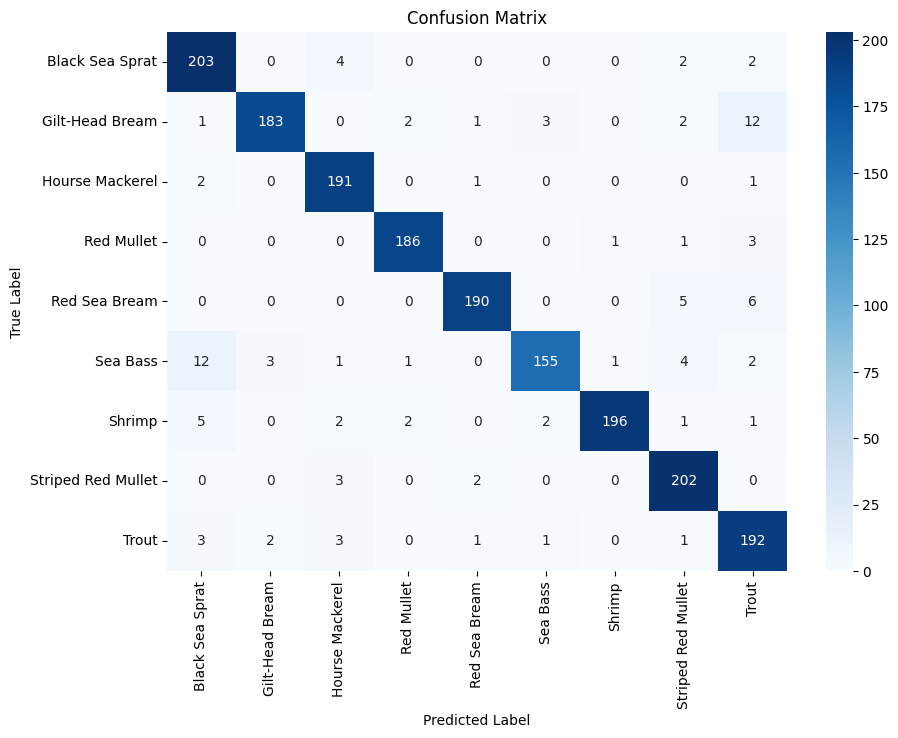

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminleri
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıfları al
y_true_classes = np.argmax(y_test, axis=1)  # Gerçek sınıflar

# Confusion matrix 
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()



In [33]:

# Classification Report - precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       211
           1       0.97      0.90      0.93       204
           2       0.94      0.98      0.96       195
           3       0.97      0.97      0.97       191
           4       0.97      0.95      0.96       201
           5       0.96      0.87      0.91       179
           6       0.99      0.94      0.96       209
           7       0.93      0.98      0.95       207
           8       0.88      0.95      0.91       203

    accuracy                           0.94      1800
   macro avg       0.95      0.94      0.94      1800
weighted avg       0.95      0.94      0.94      1800



In [34]:
# F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.9433707028186171


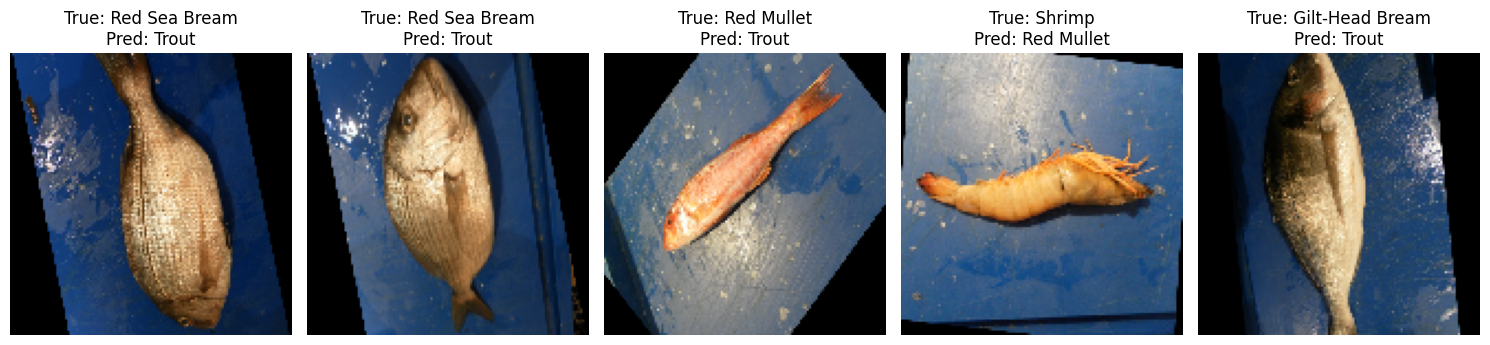

In [35]:
# Yanlış tahmin edilen indeksleri bulma
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

# Yanlış tahmin edilen ilk birkaç örneği görselleştirme
num_examples = 5  # Kaç tane yanlış tahmin edilen görüntü sayısı
plt.figure(figsize=(15, 10))
for i, idx in enumerate(incorrect_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test_processed[idx].reshape(128, 128, 3))  # Görüntülerin boyutunu ayarlayın
    plt.title(f"True: {encoder.categories_[0][y_true_classes[idx]]}\nPred: {encoder.categories_[0][y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

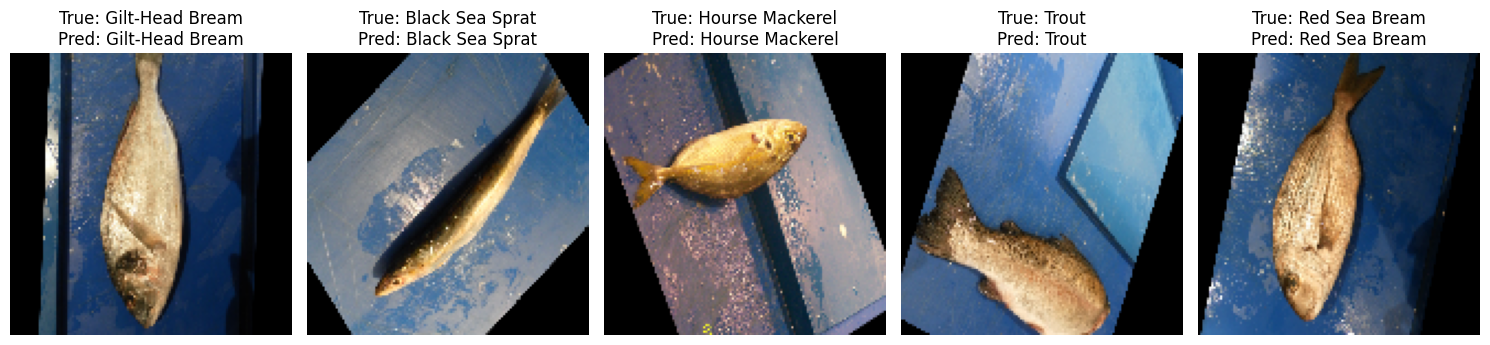

In [36]:
# Doğru tahmin edilen indeksleri bulma
correct_indices = np.where(y_pred_classes == y_true_classes)[0]

# Doğru tahmin edilen ilk birkaç örneği görselleştirme
plt.figure(figsize=(15, 10))
for i, idx in enumerate(correct_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test_processed[idx].reshape(128, 128, 3))  # Görüntülerin boyutunu ayarlayın
    plt.title(f"True: {encoder.categories_[0][y_true_classes[idx]]}\nPred: {encoder.categories_[0][y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()